In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
# Load the dataset
df = pd.read_excel("final_updated_nhc_binary_complete.xlsx")

In [25]:
# Base columns
base_cols = ['NHC', 'Fecha', 'Turno']

# Risk columns
risk_cols = [
    'Aggressive',
    'Self-Harm',
    'Absconding',
    'No_risk'
]

# Sociodemographic columns
sociodemographic_cols = [
    'Género',
    '¿Diagnóstico de esquizofrenia?',
    '¿Mayor de 35 años?',
    'Ingreso involuntario',
    'Ingreso por la presencia de riesgo de suicidio',
    'Ingreso por riesgo de hacer daño a otros'
]

# Careload indicators (columns)
careload_cols = [
    'PH', 'PD-ABVD', 'PAH', 'PCA', 'AC', 'PTCA', 'PCM', 'RAC', 'RAI', 'RCE-PSA', 'RCO'
]

# Item columns
item_cols = [
    'VIA', 'VIPM', 'AMG', 'ALT', 'CAU', 'AOPAH', 'AMED', 'SRAMF', 'OPCC', 
    'PAP', 'MVE', 'HVA', 'DCAT', 'PIDT', 'NPMT', 'AFPI', 'DCMSI', 'PII', 
    'CCA', 'SPS', 'CHP', 'CHO', 'HVT', 'CA', 'DR'
]

In [26]:
# Get unique patients for sociodemographic analysis
unique_patients = df.drop_duplicates(subset='NHC')[['NHC'] + sociodemographic_cols]

In [27]:
# -------------------------------
# OVERALL SUMMARY
# -------------------------------
print("GENERAL DATASET OVERVIEW")
print(f"Total records               : {len(df)}")
print(f"Unique patients             : {df['NHC'].nunique()}")
print(f"Unique dates                : {df['Fecha'].nunique()}")
print(f"Dataset dimensions (rows, columns): {df.shape}")
print()

GENERAL DATASET OVERVIEW
Total records               : 1825
Unique patients             : 390
Unique dates                : 357
Dataset dimensions (rows, columns): (1825, 49)



In [28]:
# -------------------------------
# SOCIODEMOGRAPHIC DISTRIBUTIONS (UNIQUE PATIENTS ONLY)
# -------------------------------
print("SOCIODEMOGRAPHIC DISTRIBUTIONS (UNIQUE PATIENTS)")
for col in sociodemographic_cols:
    print(f"\n{col}")
    print(unique_patients[col].value_counts(dropna=False))

SOCIODEMOGRAPHIC DISTRIBUTIONS (UNIQUE PATIENTS)

Género
Género
NaN    158
M      120
H      108
-        2
         2
Name: count, dtype: int64

¿Diagnóstico de esquizofrenia?
¿Diagnóstico de esquizofrenia?
N      194
NaN    158
S       33
-        4
         1
Name: count, dtype: int64

¿Mayor de 35 años?
¿Mayor de 35 años?
S      166
NaN    158
N       65
         1
Name: count, dtype: int64

Ingreso involuntario
Ingreso involuntario
NaN    158
N      129
S       97
-        5
         1
Name: count, dtype: int64

Ingreso por la presencia de riesgo de suicidio
Ingreso por la presencia de riesgo de suicidio
N      188
NaN    158
S       42
         1
-        1
Name: count, dtype: int64

Ingreso por riesgo de hacer daño a otros
Ingreso por riesgo de hacer daño a otros
N      212
NaN    158
S       11
-        8
         1
Name: count, dtype: int64


In [29]:

# -------------------------------
# RISK ITEM FREQUENCIES
# -------------------------------
print("\nRISK ITEM FREQUENCIES (Total Count per Item)")
print(df[item_cols].sum().sort_values(ascending=False))


RISK ITEM FREQUENCIES (Total Count per Item)
PII      97
DCAT     19
VIPM     19
VIA      18
SPS      15
CA       13
HVA      13
AFPI     12
HVT      10
CAU       9
AMG       9
ALT       8
CHP       7
MVE       5
CHO       4
NPMT      4
AOPAH     4
AMED      4
PAP       3
OPCC      3
SRAMF     3
CCA       2
PIDT      2
DR        2
DCMSI     1
dtype: int64


In [30]:
# -------------------------------
# CARELOAD DISTRIBUTIONS
# -------------------------------
print("\nCARELOAD ITEM FREQUENCIES (Total Count per Item)")
print(df[careload_cols].sum().sort_values(ascending=False))


CARELOAD ITEM FREQUENCIES (Total Count per Item)
RAI        90
PAH        46
PH         44
RCO        37
PTCA       25
RAC        16
PD-ABVD    13
RCE-PSA     9
AC          6
PCA         4
PCM         2
dtype: int64


In [31]:
# -------------------------------
# RISK CATEGORY DISTRIBUTIONS
# -------------------------------
print("\nRISK CATEGORIES (Total Counts)")
print(df[risk_cols].sum())


RISK CATEGORIES (Total Counts)
Aggressive     169
Self-Harm       41
Absconding      39
No_risk       1576
dtype: int64


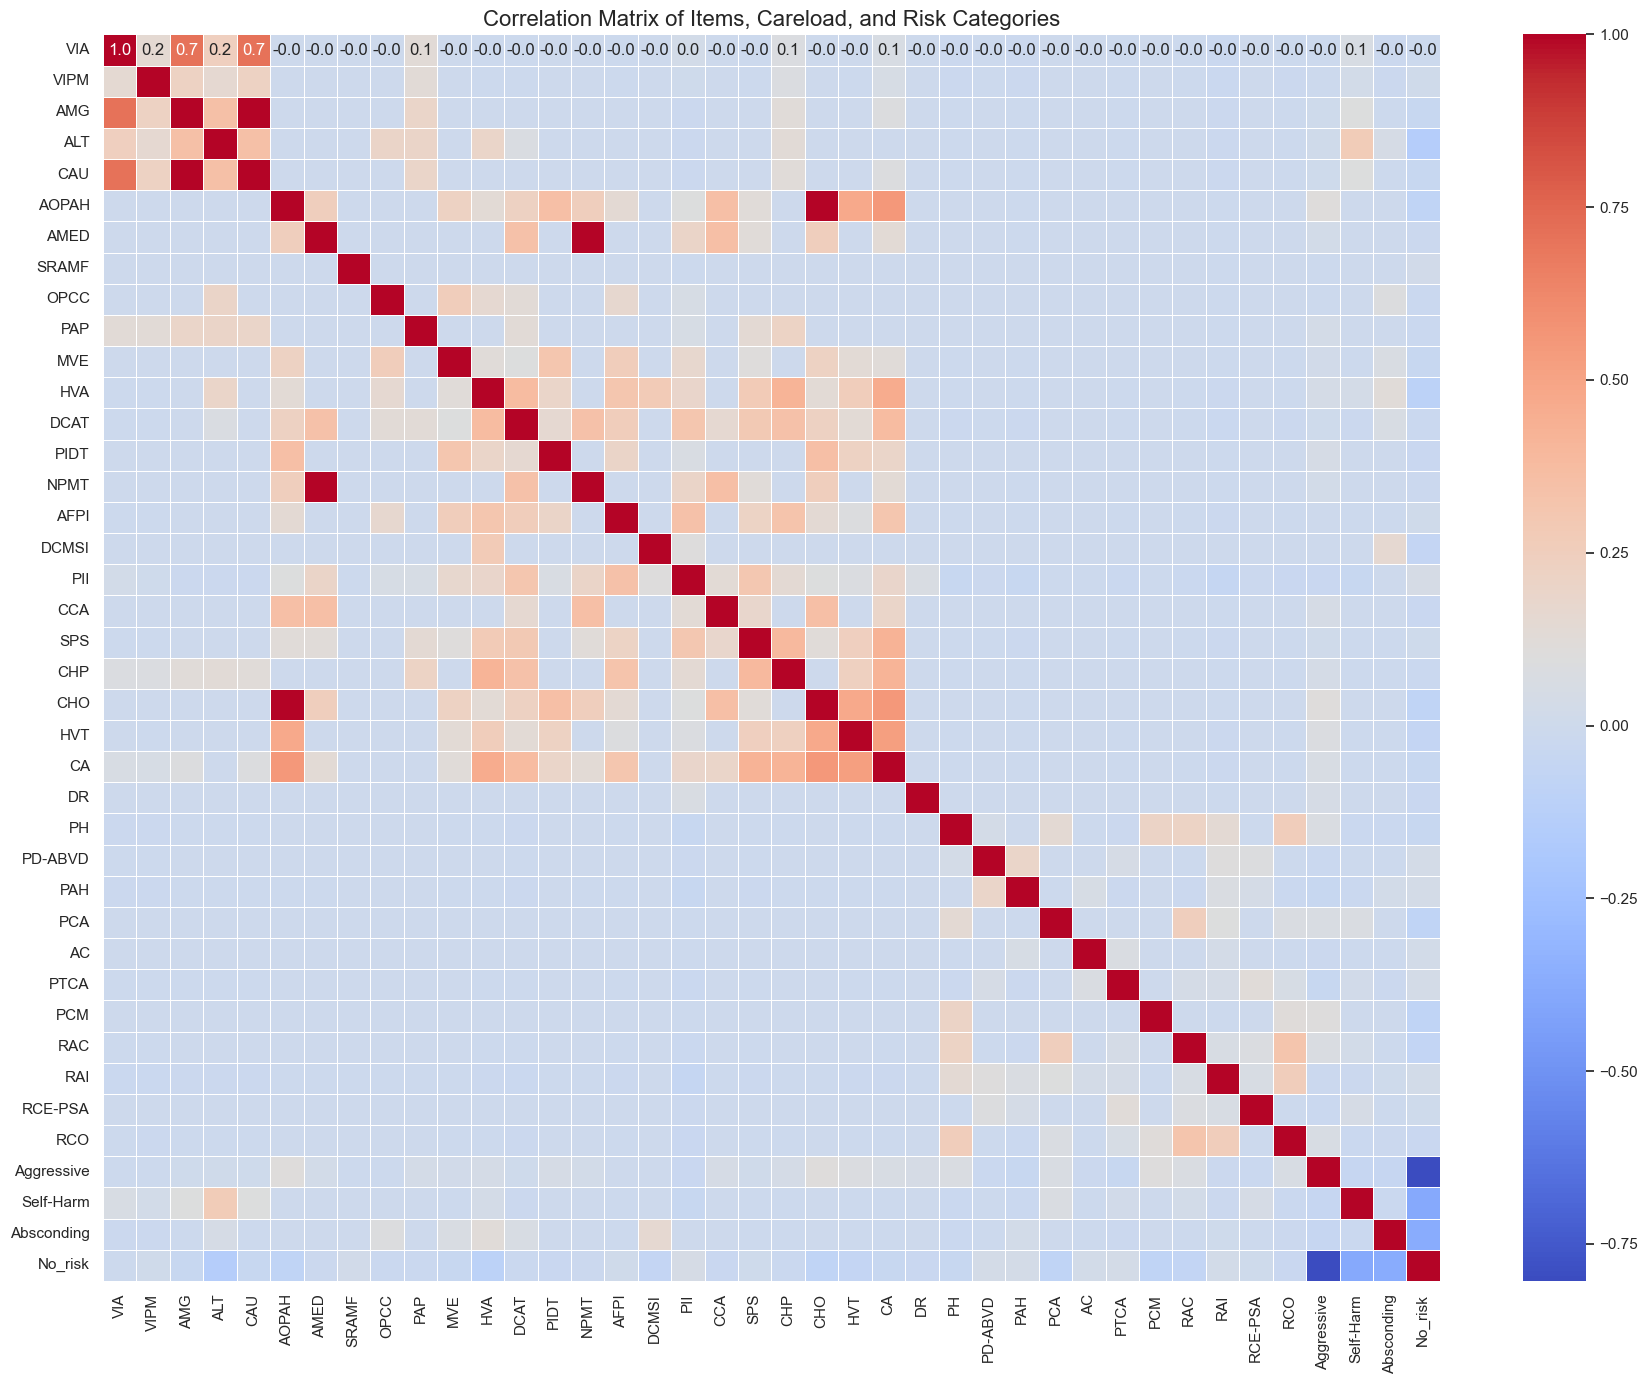

In [32]:
# --- Plot 1: Correlation matrix ---
correlation_data = df[item_cols + careload_cols + risk_cols]
corr_matrix = correlation_data.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Correlation Matrix of Items, Careload, and Risk Categories", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
# Function to detect and remove highly correlated columns
def remove_highly_correlated(df, threshold=0.9, dataset_name=""):
    # Detect columns likely to be item indicators (uppercase without hyphens)
    item_cols = [col for col in df.columns if col.isupper() and '-' not in col]

    # Compute absolute correlation matrix
    corr_matrix = df[item_cols].corr().abs()

    # Identify upper triangle pairs above the threshold (exclude diagonal)
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    high_corr = corr_pairs[corr_pairs['Correlation'] >= threshold]

    # Display highly correlated pairs
    print(f"\nHIGHLY CORRELATED PAIRS IN {dataset_name} (|correlation| ≥ {threshold}):")
    if high_corr.empty:
        print("No highly correlated pairs found.")
    else:
        print(high_corr.sort_values(by='Correlation', ascending=False))

    # Drop the second variable in each highly correlated pair
    to_drop = set(high_corr['Variable 2'])
    reduced_df = df.drop(columns=to_drop)

    return reduced_df, to_drop

# Load datasets
binary_df = pd.read_excel("binary_items_dataset.xlsx")
weighted_df = pd.read_excel("weighted_items_dataset.xlsx")

# Process datasets
binary_reduced, dropped_binary = remove_highly_correlated(binary_df, threshold=0.9, dataset_name="binary_items_dataset")
weighted_reduced, dropped_weighted = remove_highly_correlated(weighted_df, threshold=0.9, dataset_name="weighted_items_dataset")

# Save reduced datasets
binary_reduced.to_excel("binary_items_dataset_reduced.xlsx", index=False)
weighted_reduced.to_excel("weighted_items_dataset_reduced.xlsx", index=False)

# Display summary of dropped columns
print("\nDROPPED COLUMNS FROM binary_items_dataset:")
print(sorted(dropped_binary))

print("\nDROPPED COLUMNS FROM weighted_items_dataset:")
print(sorted(dropped_weighted))


HIGHLY CORRELATED PAIRS IN binary_items_dataset (|correlation| ≥ 0.9):
    Variable 1 Variable 2  Correlation
97         AMG        CAU          1.0
197      AOPAH        CHO          1.0
216       AMED       NPMT          1.0
220       AMED        CCA          1.0
374       NPMT        CCA          1.0

HIGHLY CORRELATED PAIRS IN weighted_items_dataset (|correlation| ≥ 0.9):
    Variable 1 Variable 2  Correlation
97         AMG        CAU          1.0
197      AOPAH        CHO          1.0
216       AMED       NPMT          1.0
220       AMED        CCA          1.0
374       NPMT        CCA          1.0

DROPPED COLUMNS FROM binary_items_dataset:
['CAU', 'CCA', 'CHO', 'NPMT']

DROPPED COLUMNS FROM weighted_items_dataset:
['CAU', 'CCA', 'CHO', 'NPMT']


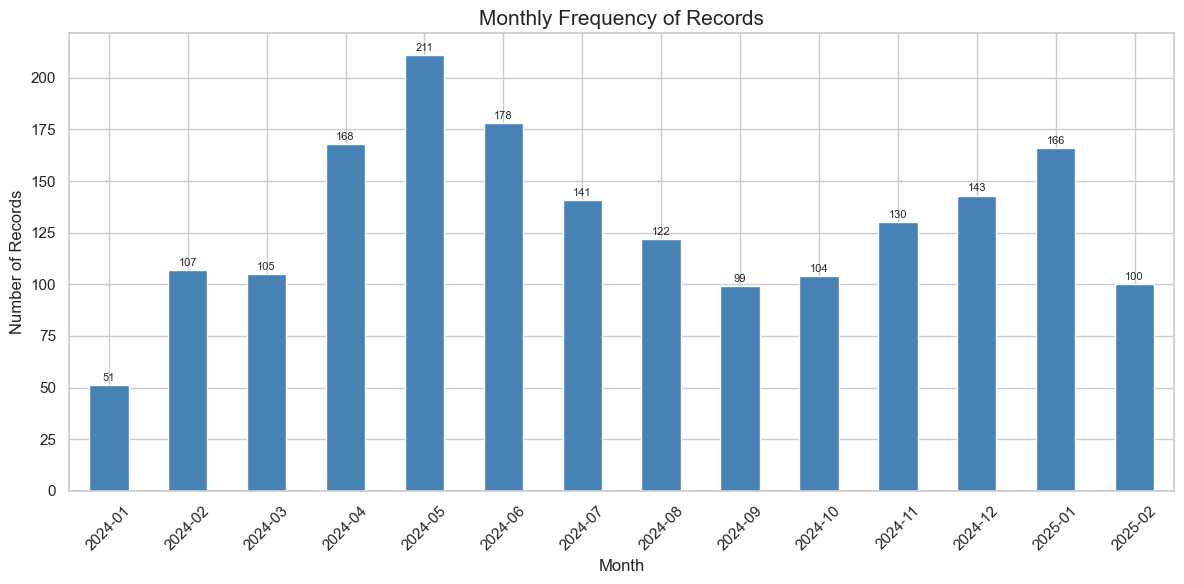

In [34]:
# Monthly record count ---
df['Month'] = df['Fecha'].dt.to_period('M')
monthly_counts = df.groupby('Month').size()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='steelblue')
plt.title("Monthly Frequency of Records", fontsize=15)
plt.xlabel("Month")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
for idx, value in enumerate(monthly_counts):
    plt.text(idx, value + 1, str(value), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

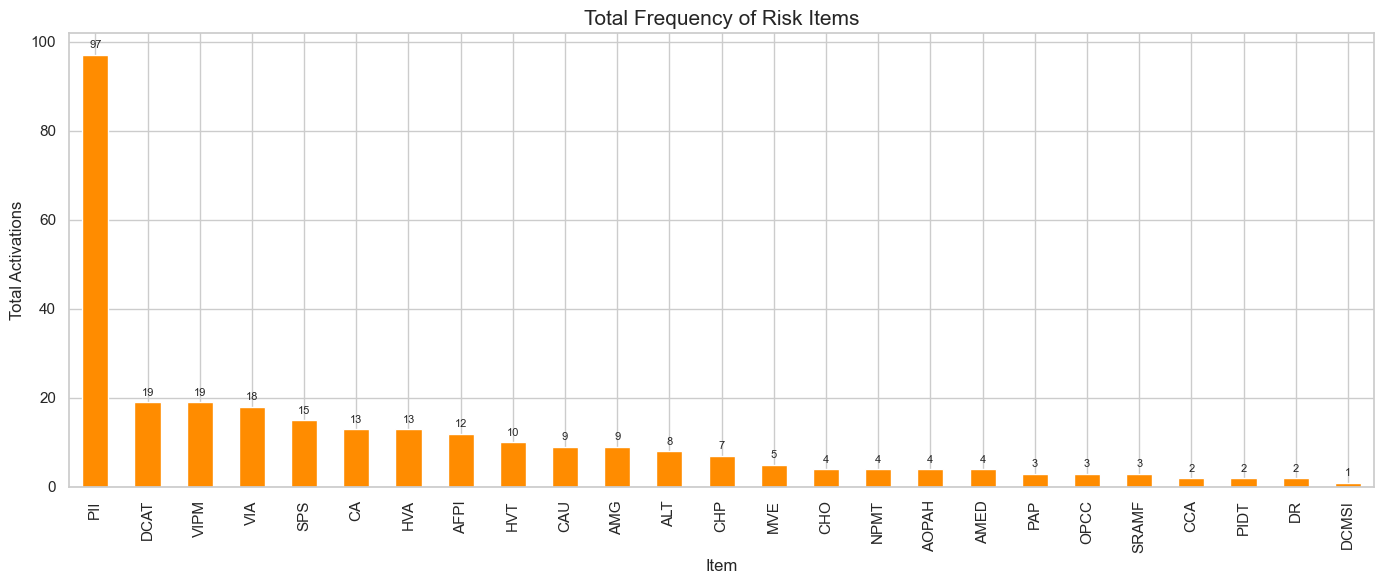

In [35]:
# Frequency of individual risk items ---
item_freq = df[item_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
item_freq.plot(kind='bar', color='darkorange')
plt.title("Total Frequency of Risk Items", fontsize=15)
plt.xlabel("Item")
plt.ylabel("Total Activations")
plt.xticks(rotation=90)
for idx, value in enumerate(item_freq):
    plt.text(idx, value + 1, str(value), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

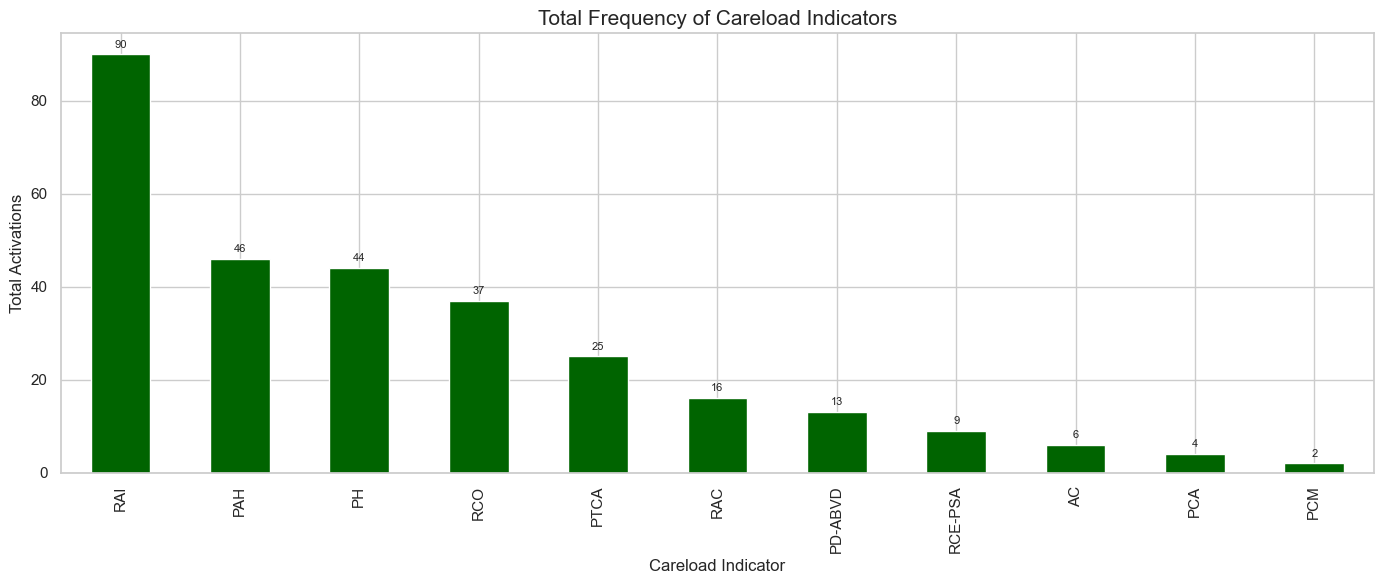

In [36]:
# Frequency of careload indicators ---
careload_freq = df[careload_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
careload_freq.plot(kind='bar', color='darkgreen')
plt.title("Total Frequency of Careload Indicators", fontsize=15)
plt.xlabel("Careload Indicator")
plt.ylabel("Total Activations")
plt.xticks(rotation=90)
for idx, value in enumerate(careload_freq):
    plt.text(idx, value + 1, str(value), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

In [37]:
# Normalize gender: only keep M and H
def normalize_gender(value):
    if pd.isna(value):
        return None
    val = str(value).strip().upper()
    if val in ['M', 'MUJER', 'F', 'FEMENINO']:
        return 'M'
    elif val in ['H', 'HOMBRE', 'MASCULINO']:
        return 'H'
    else:
        return None  # Exclude ambiguous or missing

unique_patients['Género'] = unique_patients['Género'].apply(normalize_gender)
unique_patients = unique_patients[unique_patients['Género'].isin(['M', 'H'])]

In [38]:
# Normalize all other sociodemographic columns to S (Sí) or N (No)
sociodemographic_cols = [
    '¿Diagnóstico de esquizofrenia?', '¿Mayor de 35 años?',
    'Ingreso involuntario', 'Ingreso por la presencia de riesgo de suicidio',
    'Ingreso por riesgo de hacer daño a otros'
]

def normalize_sn(value):
    if pd.isna(value):
        return 'N'
    val = str(value).strip().lower()
    return 'S' if val in ['si', 'sí', 's', '1'] else 'N'

for col in sociodemographic_cols:
    unique_patients[col] = unique_patients[col].apply(normalize_sn)

In [39]:
# Set plot style
sns.set(style="whitegrid")

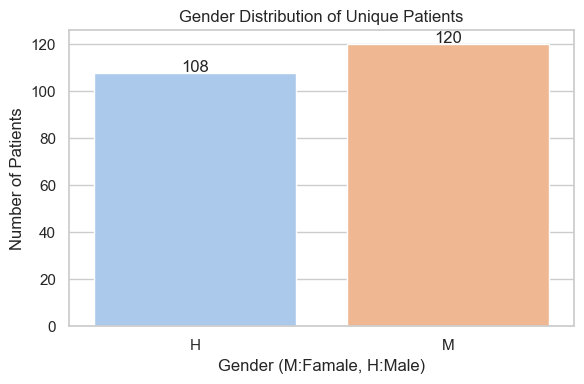

In [40]:
# Plot gender distribution
plt.figure(figsize=(6, 4))
gender_counts = unique_patients['Género'].value_counts().sort_index()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title("Gender Distribution of Unique Patients")
plt.xlabel("Gender (M:Famale, H:Male)")
plt.ylabel("Number of Patients")
for i, val in enumerate(gender_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center')
plt.tight_layout()
plt.show()

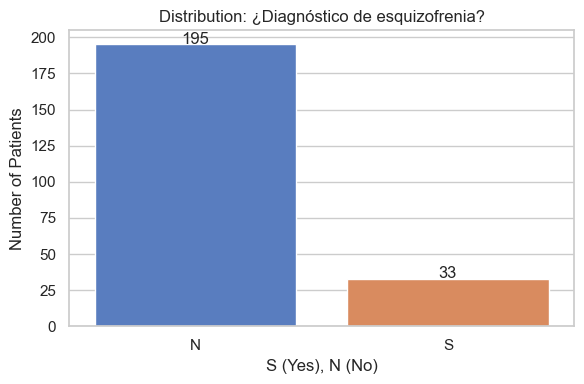

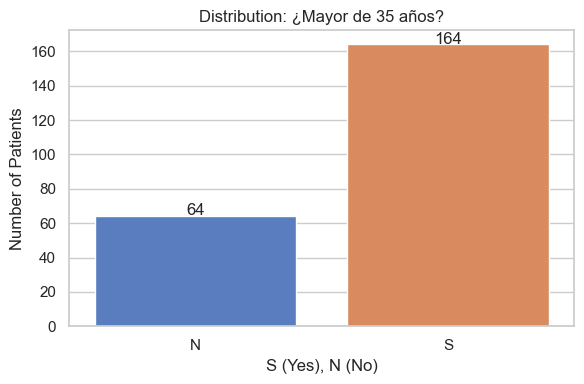

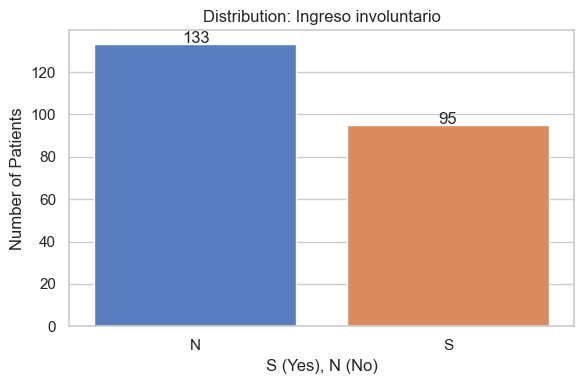

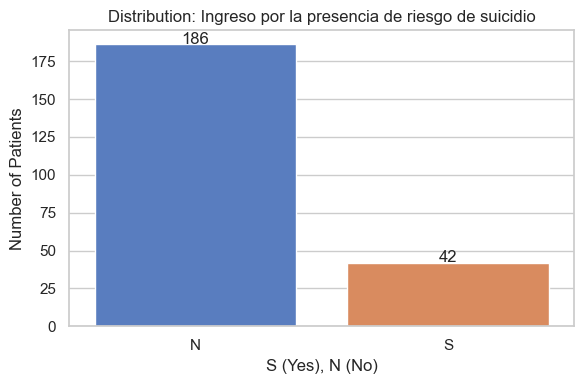

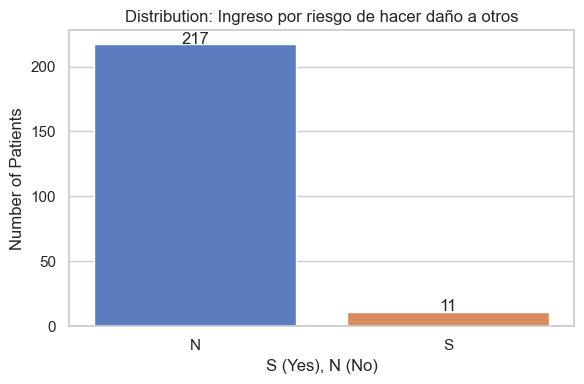

In [41]:
# Plot remaining sociodemographic variables
for col in sociodemographic_cols:
    plt.figure(figsize=(6, 4))
    counts = unique_patients[col].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, palette='muted')
    plt.title(f"Distribution: {col}")
    plt.xlabel("S (Yes), N (No)")
    plt.ylabel("Number of Patients")
    for i, val in enumerate(counts.values):
        plt.text(i, val + 0.5, str(val), ha='center')
    plt.tight_layout()
    plt.show()

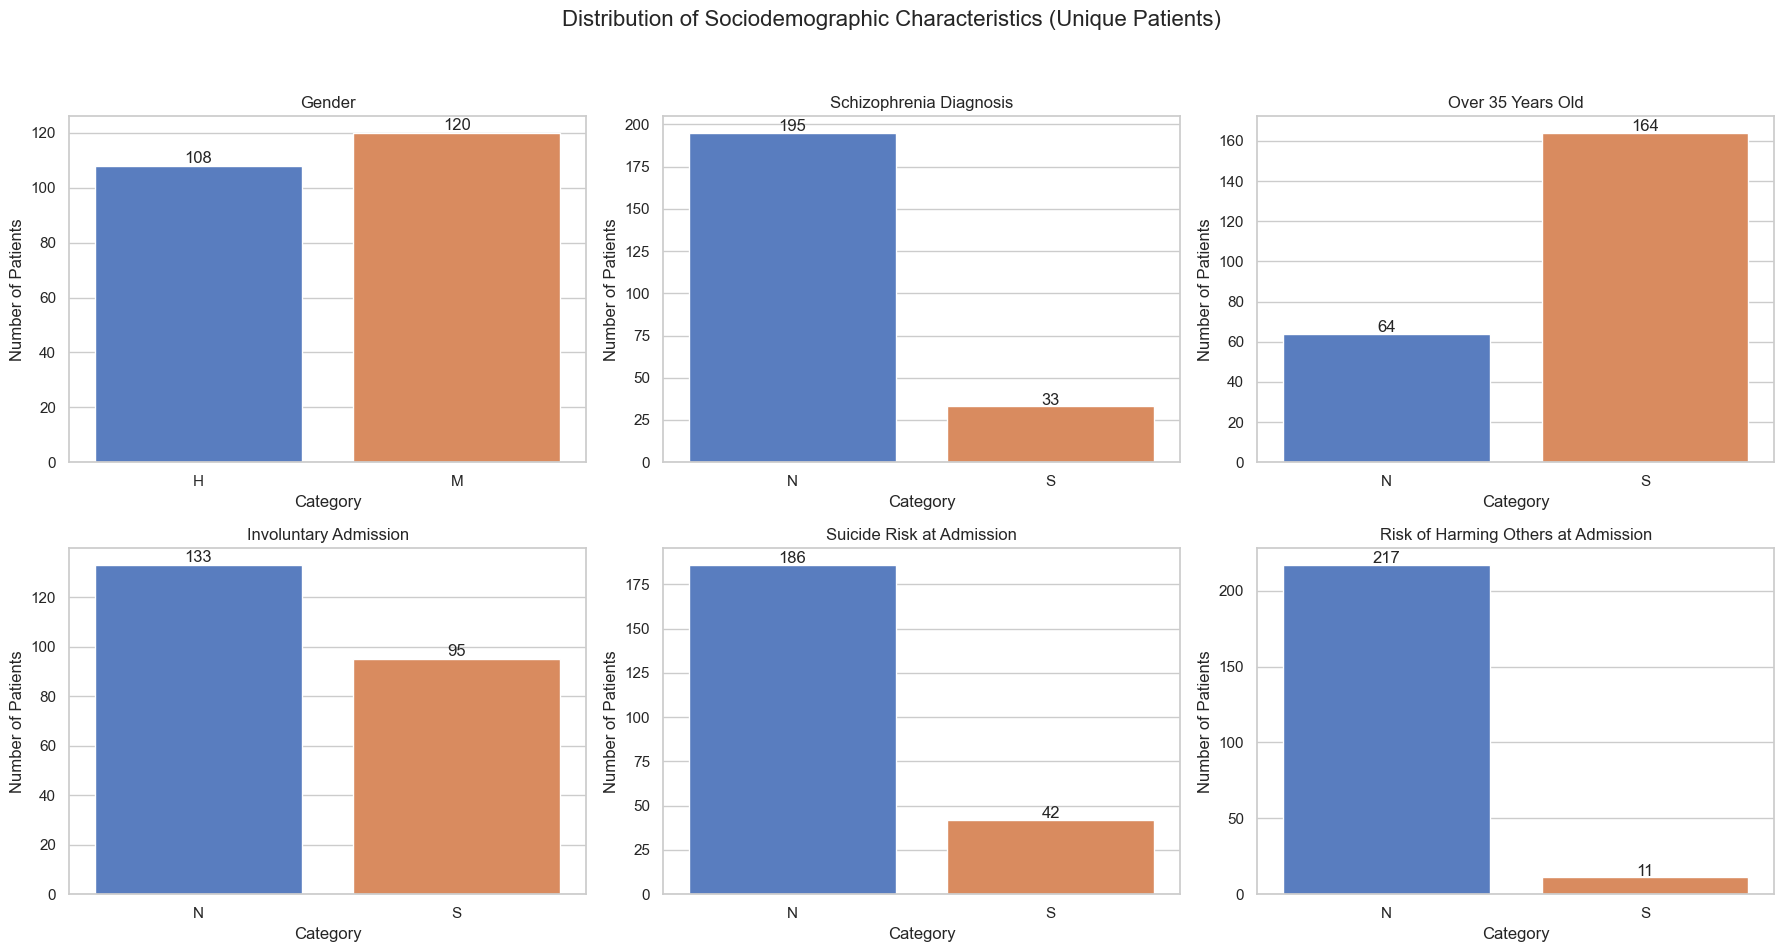

In [43]:
# Ensure consistent plot style
sns.set(style="whitegrid")

# Define the columns and their plot titles
sociodemographic_cols = [
    'Género',
    '¿Diagnóstico de esquizofrenia?',
    '¿Mayor de 35 años?',
    'Ingreso involuntario',
    'Ingreso por la presencia de riesgo de suicidio',
    'Ingreso por riesgo de hacer daño a otros'
]

plot_titles = [
    'Gender',
    'Schizophrenia Diagnosis',
    'Over 35 Years Old',
    'Involuntary Admission',
    'Suicide Risk at Admission',
    'Risk of Harming Others at Admission'
]

# Create a composite figure with 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(sociodemographic_cols):
    counts = unique_patients[col].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, palette='muted', ax=axes[i])
    axes[i].set_title(plot_titles[i])
    axes[i].set_xlabel("Category")
    axes[i].set_ylabel("Number of Patients")
    for j, val in enumerate(counts.values):
        axes[i].text(j, val + 1, str(val), ha='center')

# General figure title
plt.suptitle("Distribution of Sociodemographic Characteristics (Unique Patients)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# To save the figure, uncomment:
# plt.savefig("sociodemographic_distribution.png", dpi=300)

plt.show()

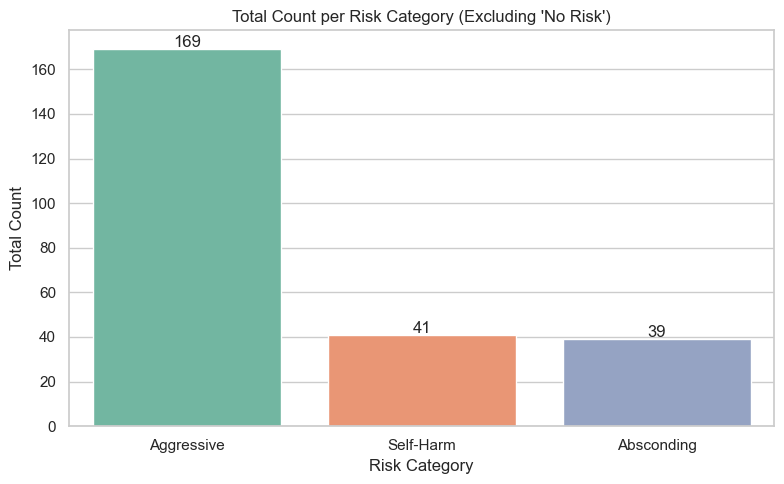

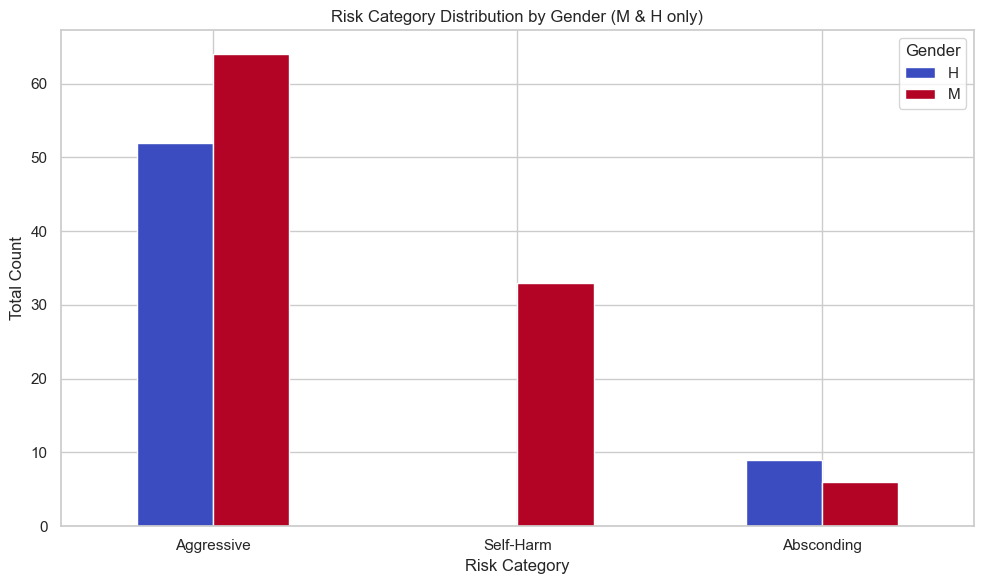

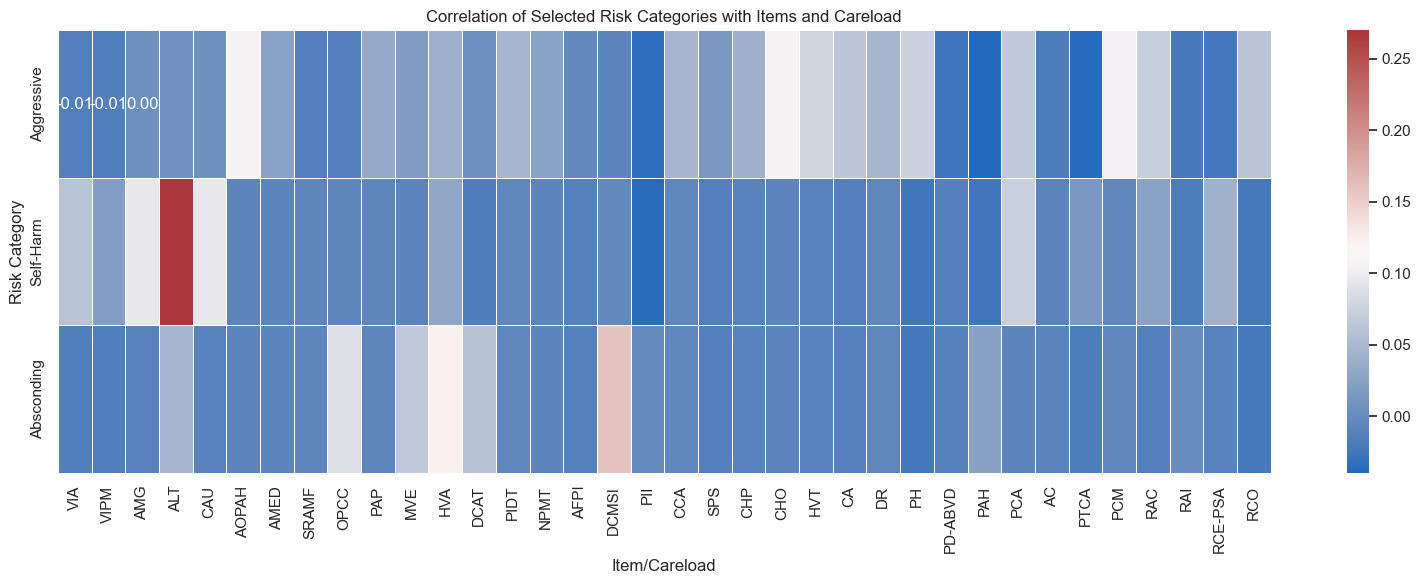

In [44]:
# -------------------------------
# ADDITIONAL RISK CATEGORY ANALYSIS PLOTS (CLEANED)
# -------------------------------

# Define focused risk categories (exclude 'No_risk')
filtered_risk_cols = ['Aggressive', 'Self-Harm', 'Absconding']

# 1. Bar plot of total counts (filtered risk categories only)
risk_sums = df[filtered_risk_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=risk_sums.index, y=risk_sums.values, palette='Set2')
plt.title("Total Count per Risk Category (Excluding 'No Risk')")
plt.ylabel("Total Count")
plt.xlabel("Risk Category")
for i, val in enumerate(risk_sums.values):
    plt.text(i, val + 1, str(val), ha='center')
plt.tight_layout()
plt.show()

# 2. Risk category distribution by gender (M & H only)
unique_patients = unique_patients.rename(columns={'Género': 'Genero'})
unique_patients = unique_patients[unique_patients['Genero'].isin(['M', 'H'])]

gender_risk = df.merge(unique_patients[['NHC', 'Genero']], on='NHC', how='left')
gender_risk = gender_risk[gender_risk['Genero'].isin(['M', 'H'])]  # ensure filter after merge
gender_risk_grouped = gender_risk.groupby('Genero')[filtered_risk_cols].sum().T

# Plot
gender_risk_grouped.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title("Risk Category Distribution by Gender (M & H only)")
plt.xlabel("Risk Category")
plt.ylabel("Total Count")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# 3. Heatmap of correlation with only the 3 risk categories
corr_data = df[item_cols + careload_cols + filtered_risk_cols]
corr_matrix_risk = corr_data.corr().loc[filtered_risk_cols, item_cols + careload_cols]

plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix_risk, cmap="vlag", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation of Selected Risk Categories with Items and Careload")
plt.xlabel("Item/Careload")
plt.ylabel("Risk Category")
plt.tight_layout()
plt.show()